<a href="https://colab.research.google.com/github/fzanart/GHDomains/blob/main/Sentence_transformers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -U sentence-transformers
!pip install flaml

     |████████████████████████████████| 79 kB 3.0 MB/s 
     |████████████████████████████████| 3.8 MB 9.3 MB/s 
     |████████████████████████████████| 1.2 MB 42.0 MB/s 
     |████████████████████████████████| 67 kB 5.0 MB/s 
     |████████████████████████████████| 895 kB 35.9 MB/s 
     |████████████████████████████████| 6.5 MB 17.3 MB/s 
     |████████████████████████████████| 596 kB 30.9 MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.0-py3-none-any.whl size=120747 sha256=86e0c41a870eda7671f5b27dc553d6ee5612a6f984d6a43ffe7cef4705cbf15c
  Stored in directory: /root/.cache/pip/wheels/83/c0/df/b6873ab7aac3f2465aa9144b6b4c41c4391cfecc027c8b07e7
Successfully built sentence-transformers
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
     |████████████████████████████████| 154 kB 5.2 MB/s 
     |████████████████████████████████| 2.0 MB 29.9 MB/s 
  Atte

In [2]:
import numpy as np
import pandas as pd
from google.colab import drive
from sentence_transformers import SentenceTransformer
from sklearn.metrics import classification_report, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from flaml import AutoML
drive.mount('/content/drive/')

Mounted at /content/drive/


In [33]:
df = pd.read_csv('/content/drive/MyDrive/GHDomains/expanded_frame_final.csv')
#df = df[['Description', 'Domain']]

In [9]:
import markdown
import lxml
from bs4 import BeautifulSoup
import re

In [34]:
df = df[['Readme','Domain']]
df

,Readme,Domain
0,![freeCodeCamp.org Social Banner](https://s3.a...,Documentation
1,"<p align=""center"">\n <a href=""https://getboot...",Web libraries and frameworks
2,"# D3: Data-Driven Documents\n\n<a href=""https:...",Web libraries and frameworks
3,# [React](https://reactjs.org/) &middot; [![Gi...,Web libraries and frameworks
4,AngularJS [![CircleCI](https://circleci.com/gh...,Web libraries and frameworks
...,...,...
4995,# Changes:\n\n * Made clickable views like a ...,Non-web libraries and frameworks
4996,# Cookies.js\n\nCookies.js is a small client-s...,Web libraries and frameworks
4997,legacy-cc\n=========\n\nThe earliest versions ...,Software tools
4998,# ELCImagePickerController\n\n*A clone of the ...,Non-web libraries and frameworks


In [32]:
def clean_htmltags(text):

    html = markdown.markdown(text)                                # convert the code to html
    soup = BeautifulSoup(html, "lxml")                            # html.parser #XML stands for "eXtensible Markup Language",
    
    [s.extract() for s in soup(['iframe', 'script'])]             # eliminate html tags 
    stripped_text = soup.get_text()                               # get the rest of the text
    stripped_text = re.sub(r'[\r|\n|\r\n]+', ' ', stripped_text)  # delete remaining tags
    text = stripped_text                                          # voila!
                                    
    return text

In [35]:
df['Readme'] = df['Readme'].astype(str)
df['Readme'] = df['Readme'].apply(lambda x: clean_htmltags(x))

In [37]:
df['Readme'] = df['Readme'].apply(lambda x: re.sub('\s{2,}', " ", x))

In [39]:
df['Readme']

0        freeCodeCamp.org's open-source codebase and c...
1        Bootstrap Sleek, intuitive, and powerful fron...
2       D3: Data-Driven Documents D3 (or D3.js) is a J...
3       React · React is a JavaScript library for buil...
4       AngularJS AngularJS lets you write client-side...
                              ...                        
4995    Changes: Made clickable views like a button cl...
4996    Cookies.js Cookies.js is a small client-side j...
4997    legacy-cc The earliest versions of the very fi...
4998    ELCImagePickerController A clone of the UIImag...
4999    _/ _/ _/ _/ _/_/ _/_/ _/_/_/ _/_/_/ _/_/_/ _/ ...
Name: Readme, Length: 5000, dtype: object

In [40]:
df['Domain'].value_counts(normalize=True)

Web libraries and frameworks        0.3070
Non-web libraries and frameworks    0.2878
Software tools                      0.1944
Application software                0.0874
Documentation                       0.0866
System software                     0.0368
Name: Domain, dtype: float64

In [41]:
sentences = df['Readme'].astype(str).to_list()
model = SentenceTransformer('sentence-transformers/all-mpnet-base-v2')
embeddings = model.encode(sentences)


Downloading:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/10.1k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/571 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/116 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/39.3k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/349 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/438M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/239 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/363 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/13.1k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [42]:
print(embeddings)

[[-0.02660924  0.05932906 -0.03961322 ... -0.07373533  0.10230879
  -0.01512107]
 [ 0.0120114  -0.02113934 -0.04660942 ... -0.00651845  0.01397459
  -0.040216  ]
 [-0.01302167 -0.03687513 -0.04354367 ...  0.00431149 -0.01798771
  -0.03854522]
 ...
 [-0.02303047  0.05609551  0.00355551 ... -0.01770959 -0.0332825
  -0.01947443]
 [ 0.04502847 -0.01037439  0.00694316 ... -0.02024421  0.01463224
  -0.0344638 ]
 [-0.03260802 -0.04970478 -0.05689266 ... -0.03127809  0.0225223
  -0.01309731]]


In [43]:
X_train, X_test, y_train, y_test = train_test_split(embeddings, df['Domain'], test_size=0.1, random_state=42, stratify=df['Domain'])

In [44]:
automl = AutoML()
settings = {
    "time_budget": 1000,  # total running time in seconds
    "metric": 'macro_f1',  # can be: 'r2', 'rmse', 'mae', 'mse', 'accuracy', 'roc_auc', 'roc_auc_ovr',
                           # 'roc_auc_ovo', 'log_loss', 'mape', 'f1', 'ap', 'ndcg', 'micro_f1', 'macro_f1'
    "task": 'classification',  # task type
    "eval_method" : 'cv',
    "n_splits" : 10,
    "seed": 42,    # random seed
}

In [45]:
automl.fit(X_train=X_train, y_train=y_train, **settings)

[flaml.automl: 03-09 03:35:40] {2068} INFO - task = classification
[flaml.automl: 03-09 03:35:40] {2070} INFO - Data split method: stratified
[flaml.automl: 03-09 03:35:40] {2074} INFO - Evaluation method: cv
[flaml.automl: 03-09 03:35:40] {2155} INFO - Minimizing error metric: 1-macro_f1
[flaml.automl: 03-09 03:35:40] {2248} INFO - List of ML learners in AutoML Run: ['lgbm', 'rf', 'xgboost', 'extra_tree', 'xgb_limitdepth', 'lrl1']
[flaml.automl: 03-09 03:35:40] {2501} INFO - iteration 0, current learner lgbm
[flaml.automl: 03-09 03:35:57] {2617} INFO - Estimated sufficient time budget=171765s. Estimated necessary time budget=3959s.
[flaml.automl: 03-09 03:35:57] {2669} INFO -  at 17.2s,	estimator lgbm's best error=0.7417,	best estimator lgbm's best error=0.7417
[flaml.automl: 03-09 03:35:57] {2501} INFO - iteration 1, current learner lgbm
[flaml.automl: 03-09 03:36:22] {2669} INFO -  at 41.9s,	estimator lgbm's best error=0.7417,	best estimator lgbm's best error=0.7417
[flaml.automl: 0

In [46]:
'''retrieve best config and best learner'''
print('Best ML leaner:', automl.best_estimator)
print('Best hyperparmeter config:', automl.best_config)
print('Best accuracy on validation data: {0:.4g}'.format(1-automl.best_loss))
print('Training duration of best run: {0:.4g} s'.format(automl.best_config_train_time))

Best ML leaner: lgbm
Best hyperparmeter config: {'n_estimators': 37, 'num_leaves': 9, 'min_child_samples': 13, 'learning_rate': 0.21480951571013288, 'log_max_bin': 6, 'colsample_bytree': 0.996498378007316, 'reg_alpha': 0.002255250947893723, 'reg_lambda': 0.10239167483099826}
Best accuracy on validation data: 0.5483
Training duration of best run: 6.934 s


In [47]:
'''compute predictions of testing dataset''' 
y_pred = automl.predict(X_test)
y_pred_proba = automl.predict_proba(X_test)[:,1]

In [48]:
target_names, counts = np.unique(y_test, return_counts=True)
print(np.asarray((target_names, counts)).T)

[['Application software' 44]
 ['Documentation' 43]
 ['Non-web libraries and frameworks' 144]
 ['Software tools' 97]
 ['System software' 18]
 ['Web libraries and frameworks' 154]]


In [49]:
print(classification_report(y_test, y_pred, target_names=target_names))

                                  precision    recall  f1-score   support

            Application software       0.50      0.23      0.31        44
                   Documentation       0.56      0.35      0.43        43
Non-web libraries and frameworks       0.65      0.70      0.67       144
                  Software tools       0.57      0.66      0.61        97
                 System software       0.25      0.11      0.15        18
    Web libraries and frameworks       0.74      0.85      0.79       154

                        accuracy                           0.65       500
                       macro avg       0.54      0.48      0.50       500
                    weighted avg       0.63      0.65      0.63       500



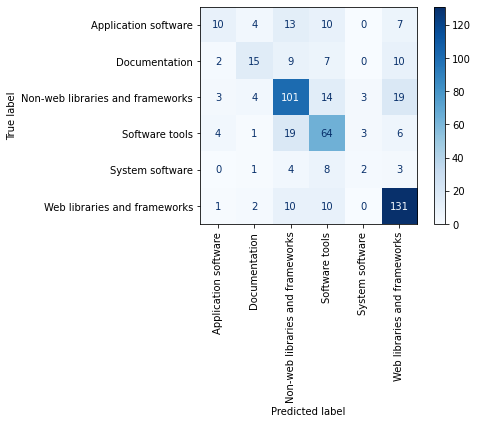

In [50]:
cnf_matrix = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cnf_matrix, display_labels=target_names).plot(cmap=plt.cm.Blues, xticks_rotation='vertical')